In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import sklearn
import shap
%matplotlib inline
from xgboost import XGBClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay

In [2]:
plt.style.use("seaborn")

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


## Import the data

In [3]:
IND_a= pd.read_csv("../Datasets/eca_2021_access.csv")
IND_u= pd.read_csv('../Datasets/eca_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [4]:
y.value_counts()

0    12013
1     6009
Name: fin34a, dtype: int64

In [5]:
sup= IND_a[IND_a.columns[:4]]
sup

,female,age,educ,inc_q
0,1,6.0,1,4
1,1,6.0,2,4
2,2,6.0,2,4
3,1,5.0,1,1
4,1,4.0,1,1
...,...,...,...,...
18017,2,1.0,1,4
18018,1,2.0,2,5
18019,1,2.0,2,2
18020,1,3.0,2,2


In [6]:
contingency_table = pd.crosstab(IND_a['educ'], IND_a['inc_q'])
contingency_table

inc_q,1,2,3,4,5
educ,,,,,
1,705,567,542,452,376
2,1675,1946,2128,2101,2110
3,463,620,836,1280,2221


In [7]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

In [8]:
IND_a= IND_a.drop(columns= ["account_mob", "fin1_1a", "fin1_1b"])
IND_a

,account_fin,fin2,fin7,mobileowner,internetaccess
0,Yes,No,No,Yes,No
1,No,No,NaN,Yes,No
2,No,No,NaN,Yes,No
3,No,No,NaN,Yes,No
4,No,No,NaN,Yes,No
...,...,...,...,...,...
18017,No,No,NaN,Yes,Yes
18018,Yes,Yes,No,Yes,No
18019,No,No,NaN,Yes,Yes
18020,Yes,Yes,No,No,No


In [9]:
IND_u= IND_u.drop(columns= ["fin1_1a", "fin1_1b", "fin26", "fin28","fin17b", "merchantpay_dig"])
IND_u

,fin4,fin5,fin8,fin9,fin10,fin10b,fin14_1,fin14a,fin14a1,fin14b,...,fin22b,fin30,fin31a,fin31b,fin32,fin37,fin38,saved,borrowed,anydigpayment
0,NaN,Yes,NaN,Yes,Yes,Yes,2,No,No,No,...,Yes,Yes,No,No,No,1,Yes,2,1,1
1,NaN,NaN,NaN,NaN,NaN,NaN,2,No,No,No,...,No,Yes,No,No,No,2,Yes,2,2,2
2,NaN,NaN,NaN,NaN,NaN,NaN,2,No,No,No,...,No,Yes,No,No,No,2,Yes,2,2,2
3,NaN,NaN,NaN,NaN,NaN,NaN,2,No,No,No,...,No,Yes,No,No,No,2,No,2,2,2
4,NaN,NaN,NaN,NaN,NaN,NaN,2,No,No,No,...,No,Yes,No,No,No,2,No,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18017,NaN,NaN,NaN,NaN,NaN,NaN,2,No,No,No,...,No,No,NaN,NaN,Yes,2,No,2,2,2
18018,Yes,No,NaN,No,No,No,2,No,No,No,...,Yes,Yes,No,No,No,1,Yes,2,1,1
18019,NaN,NaN,NaN,NaN,NaN,NaN,2,No,No,No,...,Yes,No,NaN,NaN,No,2,No,1,1,2
18020,No,No,NaN,No,No,No,2,No,No,No,...,No,Yes,No,No,No,2,No,2,2,2


## Implementing MCA

In [10]:
mca_a = prince.MCA(n_components=6)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names_a = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names_a)
IND_a_index

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6
0,0.384713,0.412850,-0.420040,-0.724339,0.450500,-0.197560
1,1.344641,-0.077264,-0.007726,-0.841623,-0.217466,-0.019330
2,1.344641,-0.077264,-0.007726,-0.841623,-0.217466,-0.019330
3,1.344641,-0.077264,-0.007726,-0.841623,-0.217466,-0.019330
4,1.344641,-0.077264,-0.007726,-0.841623,-0.217466,-0.019330
...,...,...,...,...,...,...
18017,0.796380,-0.808618,-0.003879,0.201311,-0.174940,-0.000458
18018,-0.083383,0.702960,-0.344572,-0.745187,-0.180567,0.005108
18019,0.796380,-0.808618,-0.003879,0.201311,-0.174940,-0.000458
18020,0.536593,1.887589,-0.037232,0.406887,-0.096913,0.005855


In [11]:
mca_u = prince.MCA(n_components=20)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names_u = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names_u)
IND_u_index

,uPC1,uPC2,uPC3,uPC4,uPC5,uPC6,uPC7,uPC8,uPC9,uPC10,uPC11,uPC12,uPC13,uPC14,uPC15,uPC16,uPC17,uPC18,uPC19,uPC20
0,-0.117932,-0.070510,0.212479,-0.422693,0.005713,-0.027670,-0.523618,0.344902,-0.227473,0.066142,0.220879,-0.045382,-0.127604,-0.100259,0.055190,-0.194854,-0.156625,0.021829,-0.051568,0.050680
1,-0.783608,-0.042543,-0.275030,-0.290107,-0.287434,0.046507,-0.031966,0.169805,-0.259354,0.019081,-0.158735,0.176815,-0.065874,0.067785,-0.008498,-0.181619,0.030887,0.116536,-0.046217,0.003438
2,-0.783608,-0.042543,-0.275030,-0.290107,-0.287434,0.046507,-0.031966,0.169805,-0.259354,0.019081,-0.158735,0.176815,-0.065874,0.067785,-0.008498,-0.181619,0.030887,0.116536,-0.046217,0.003438
3,-0.734302,-0.186250,-0.307374,-0.210551,-0.248408,0.035359,0.124439,-0.110303,0.046287,-0.013857,-0.016674,-0.039175,0.050684,0.060888,0.025884,-0.000182,-0.043086,-0.116825,-0.065382,-0.010327
4,-0.734302,-0.186250,-0.307374,-0.210551,-0.248408,0.035359,0.124439,-0.110303,0.046287,-0.013857,-0.016674,-0.039175,0.050684,0.060888,0.025884,-0.000182,-0.043086,-0.116825,-0.065382,-0.010327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18017,-0.628749,-0.395212,-0.373051,0.462575,0.058232,-0.155633,-0.054495,-0.192190,0.233299,-0.009085,-0.085356,-0.021866,0.073208,-0.112456,-0.039971,0.055908,0.045776,0.370282,-0.046560,0.027066
18018,-0.399354,0.287754,0.793234,-0.132280,0.043070,0.026286,0.022835,0.290384,-0.390229,0.075597,0.252085,-0.253835,-0.004988,-0.233135,0.047950,-0.286629,0.083350,0.013230,0.023331,-0.126378
18019,-0.526824,-0.580762,-0.137385,0.101313,0.782823,-0.058972,0.061988,0.023939,-0.078100,0.022029,0.193223,0.085169,-0.154754,-0.150752,0.007708,0.163868,0.039864,-0.029813,0.021197,-0.014193
18020,-0.714001,0.393770,0.456419,0.160821,-0.130202,0.002841,0.423478,-0.165140,-0.001560,-0.047354,0.041626,-0.099237,-0.026530,0.237008,-0.033832,0.104026,-0.109632,-0.063044,-0.122054,-0.000132


In [12]:
X = pd.concat([IND_a_index, IND_u_index, sup], axis=1)
X

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,uPC1,uPC2,uPC3,uPC4,...,uPC15,uPC16,uPC17,uPC18,uPC19,uPC20,female,age,educ,inc_q
0,0.384713,0.412850,-0.420040,-0.724339,0.450500,-0.197560,-0.117932,-0.070510,0.212479,-0.422693,...,0.055190,-0.194854,-0.156625,0.021829,-0.051568,0.050680,1,6.0,1,4
1,1.344641,-0.077264,-0.007726,-0.841623,-0.217466,-0.019330,-0.783608,-0.042543,-0.275030,-0.290107,...,-0.008498,-0.181619,0.030887,0.116536,-0.046217,0.003438,1,6.0,2,4
2,1.344641,-0.077264,-0.007726,-0.841623,-0.217466,-0.019330,-0.783608,-0.042543,-0.275030,-0.290107,...,-0.008498,-0.181619,0.030887,0.116536,-0.046217,0.003438,2,6.0,2,4
3,1.344641,-0.077264,-0.007726,-0.841623,-0.217466,-0.019330,-0.734302,-0.186250,-0.307374,-0.210551,...,0.025884,-0.000182,-0.043086,-0.116825,-0.065382,-0.010327,1,5.0,1,1
4,1.344641,-0.077264,-0.007726,-0.841623,-0.217466,-0.019330,-0.734302,-0.186250,-0.307374,-0.210551,...,0.025884,-0.000182,-0.043086,-0.116825,-0.065382,-0.010327,1,4.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18017,0.796380,-0.808618,-0.003879,0.201311,-0.174940,-0.000458,-0.628749,-0.395212,-0.373051,0.462575,...,-0.039971,0.055908,0.045776,0.370282,-0.046560,0.027066,2,1.0,1,4
18018,-0.083383,0.702960,-0.344572,-0.745187,-0.180567,0.005108,-0.399354,0.287754,0.793234,-0.132280,...,0.047950,-0.286629,0.083350,0.013230,0.023331,-0.126378,1,2.0,2,5
18019,0.796380,-0.808618,-0.003879,0.201311,-0.174940,-0.000458,-0.526824,-0.580762,-0.137385,0.101313,...,0.007708,0.163868,0.039864,-0.029813,0.021197,-0.014193,1,2.0,2,2
18020,0.536593,1.887589,-0.037232,0.406887,-0.096913,0.005855,-0.714001,0.393770,0.456419,0.160821,...,-0.033832,0.104026,-0.109632,-0.063044,-0.122054,-0.000132,1,3.0,2,2


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 64)

## Logistic regression

In [14]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: .62, 1: .92}], 
              'C': [i for i in range(1,2)]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [15]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 1, 'class_weight': {0: 0.62, 1: 0.92}}
Best score: 0.9289403145865631


In [16]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)

In [17]:

best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_)
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9786326731294108
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      2393
           1       0.88      1.00      0.93      1212

    accuracy                           0.95      3605
   macro avg       0.94      0.96      0.95      3605
weighted avg       0.96      0.95      0.95      3605



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


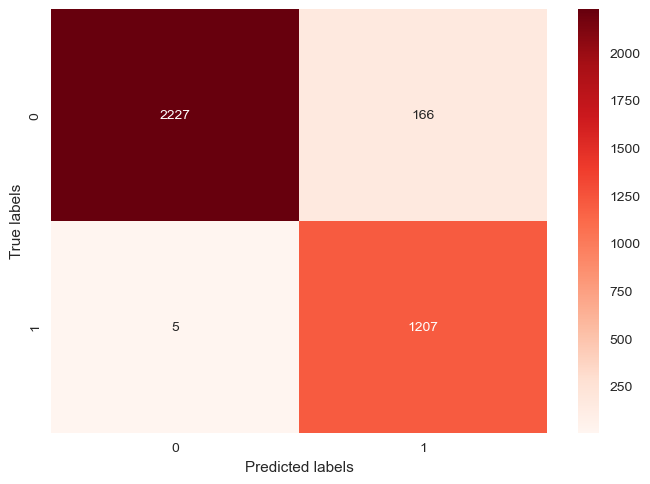

In [18]:
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [19]:
f1_score(y_test, y_pred)

0.9338491295938104

In [20]:
acc_1= accuracy_score(y_test, y_pred)
pre_1= precision_score(y_test, y_pred)
rec_1= recall_score(y_test, y_pred)
f_1_1= f1_score(y_test, y_pred)

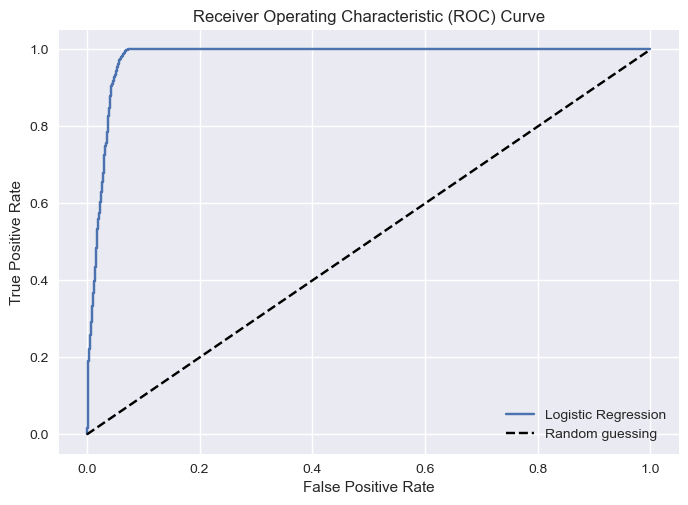

In [21]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [22]:
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [i for i in range(132,133)],
    'max_depth': [i for i in range(12,13)],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'class_weight': [{0: .49, 1: .72}]
}
rf = RandomForestClassifier(random_state= 42)

In [23]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'class_weight': {0: 0.49, 1: 0.72}, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 132}
Best score: 0.9173504074889053


In [24]:
auc2 = roc_auc_score(y_test, proba[:,1])
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9791426175630519
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2393
           1       0.88      0.98      0.93      1212

    accuracy                           0.95      3605
   macro avg       0.93      0.96      0.94      3605
weighted avg       0.95      0.95      0.95      3605



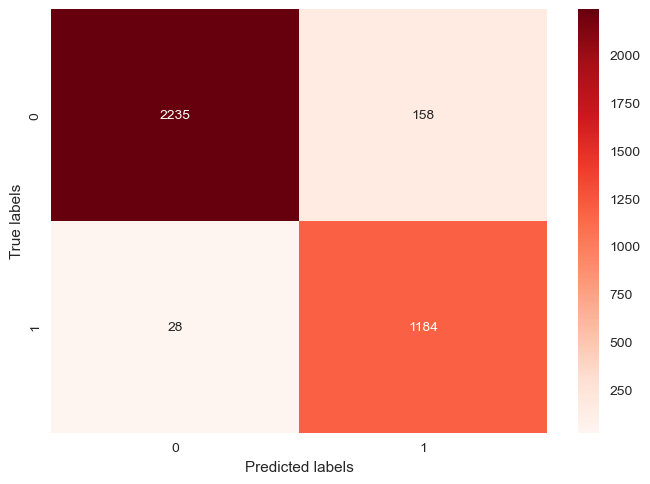

In [25]:
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [26]:
acc_2= accuracy_score(y_test, y_pred)
pre_2= precision_score(y_test, y_pred)
rec_2= recall_score(y_test, y_pred)
f_1_2= f1_score(y_test, y_pred)

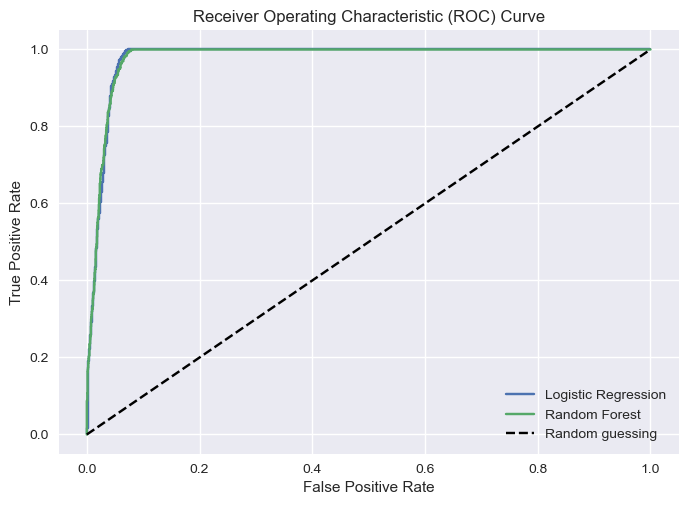

In [27]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [28]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [29]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [10],
    'learning_rate': [.1],
    'n_estimators': [376],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 376, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.9150745377652468


In [30]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]

In [31]:
auc3 = roc_auc_score(y_test, y_)
print('AUC:', auc3)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9783416703559198
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      2393
           1       0.89      0.95      0.92      1212

    accuracy                           0.94      3605
   macro avg       0.93      0.95      0.94      3605
weighted avg       0.95      0.94      0.94      3605



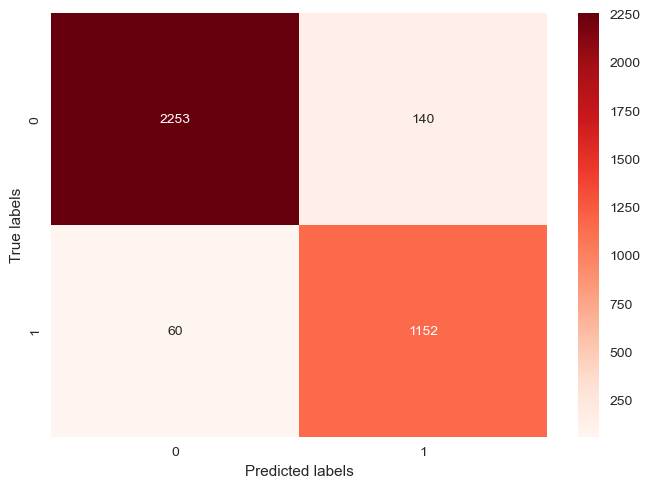

In [32]:
cm3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [33]:
acc_3= accuracy_score(y_test, y_pred)
pre_3= precision_score(y_test, y_pred)
rec_3= recall_score(y_test, y_pred)
f_1_3= f1_score(y_test, y_pred)

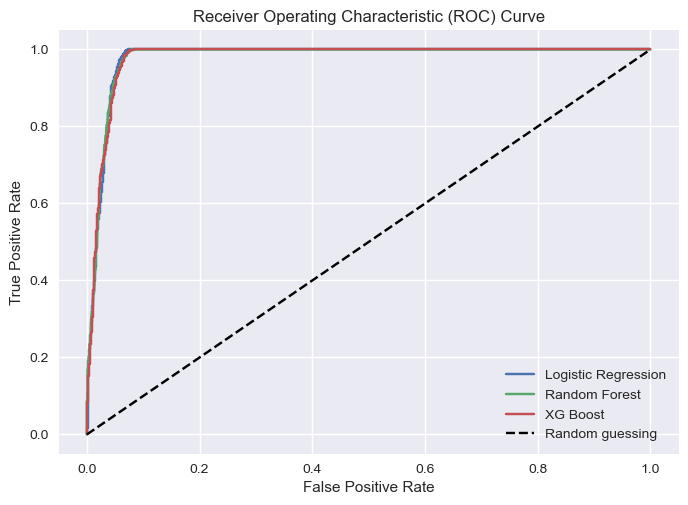

In [34]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Artificial Neural Network

In [35]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [36]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [37]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
361/361 [==============================] - 0s 746us/step - loss: 0.3083 - precision: 0.8136 - recall: 0.7996 - val_loss: 0.1696 - val_precision: 0.8724 - val_recall: 0.9652
Epoch 2/50
361/361 [==============================] - 0s 531us/step - loss: 0.1578 - precision: 0.8744 - recall: 0.9753 - val_loss: 0.1537 - val_precision: 0.8738 - val_recall: 0.9779
Epoch 3/50
361/361 [==============================] - 0s 505us/step - loss: 0.1477 - precision: 0.8763 - recall: 0.9813 - val_loss: 0.1503 - val_precision: 0.8723 - val_recall: 0.9863
Epoch 4/50
361/361 [==============================] - 0s 528us/step - loss: 0.1445 - precision: 0.8776 - recall: 0.9823 - val_loss: 0.1499 - val_precision: 0.8763 - val_recall: 0.9705
Epoch 5/50
361/361 [==============================] - 0s 526us/step - loss: 0.1432 - precision: 0.8795 - recall: 0.9802 - val_loss: 0.1494 - val_precision: 0.8727 - val_recall: 0.9821
Epoch 6/50
361/361 [==============================] - 0s 521us/step - loss: 0.14

361/361 [==============================] - 0s 511us/step - loss: 0.1020 - precision: 0.9071 - recall: 0.9891 - val_loss: 0.1722 - val_precision: 0.8669 - val_recall: 0.9884
Epoch 46/50
361/361 [==============================] - 0s 499us/step - loss: 0.1021 - precision: 0.9085 - recall: 0.9906 - val_loss: 0.1649 - val_precision: 0.8737 - val_recall: 0.9768
Epoch 47/50
361/361 [==============================] - 0s 488us/step - loss: 0.1012 - precision: 0.9095 - recall: 0.9904 - val_loss: 0.1630 - val_precision: 0.8808 - val_recall: 0.9579
Epoch 48/50
361/361 [==============================] - 0s 487us/step - loss: 0.1000 - precision: 0.9106 - recall: 0.9904 - val_loss: 0.1749 - val_precision: 0.8805 - val_recall: 0.9547
Epoch 49/50
361/361 [==============================] - 0s 486us/step - loss: 0.1011 - precision: 0.9096 - recall: 0.9880 - val_loss: 0.1621 - val_precision: 0.8788 - val_recall: 0.9631
Epoch 50/50
361/361 [==============================] - 0s 494us/step - loss: 0.0975 - p

In [38]:
y_ = ann.predict(X_test)

113/113 [==============================] - 0s 587us/step


In [39]:
y_= y_.reshape(y_.shape[0],)

In [40]:
y_pred= np.array([round(i+.25) for i in y_])

In [41]:
auc4 = roc_auc_score(y_test, y_)
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9786857707918722
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      2393
           1       0.89      0.98      0.93      1212

    accuracy                           0.95      3605
   macro avg       0.94      0.96      0.95      3605
weighted avg       0.96      0.95      0.95      3605



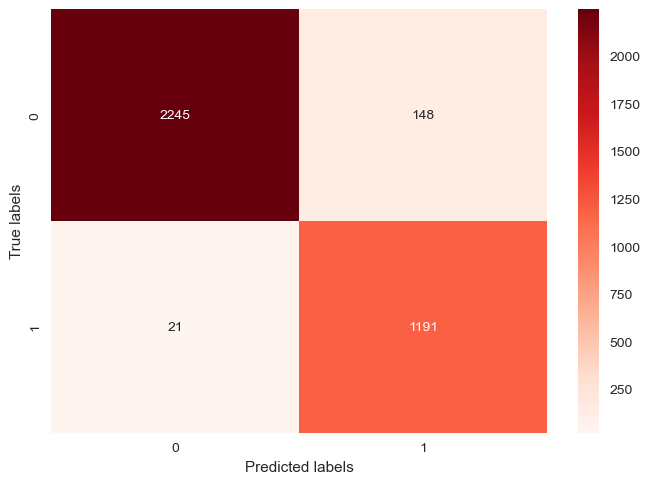

In [42]:
cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [43]:
acc_4= accuracy_score(y_test, y_pred)
pre_4= precision_score(y_test, y_pred)
rec_4= recall_score(y_test, y_pred)
f_1_4= f1_score(y_test, y_pred)

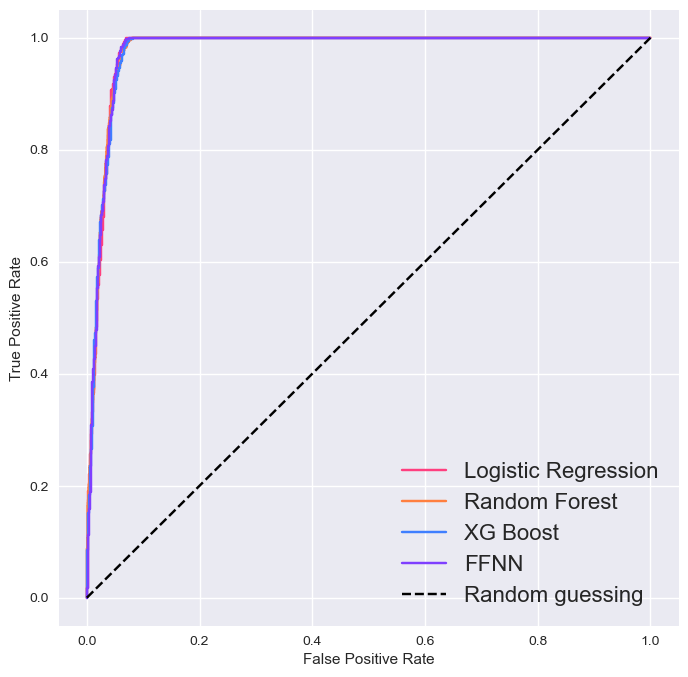

In [44]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Logistic Regression', color= "#ff3f7f")
plt.plot(fpr2, tpr2, label='Random Forest', color= "#ff7f3f")
plt.plot(fpr3, tpr3, label='XG Boost', color= "#3f7fff")
plt.plot(fpr4, tpr4, label='FFNN', color= "#7f3fff")
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.savefig("../../images/roc_eca.png")
plt.show()

## Model Evaluations

In [45]:
data= {"Metrics":["Accuracy", "Recall", "Precision", "F1-Score", "AUC"],
       "LR":[round(acc_1,4), round(rec_1,4), round(pre_1,4), round(f_1_1,4), round(auc1,4)], 
       "RF":[round(acc_2,4), round(rec_2,4), round(pre_2,4), round(f_1_2,4), round(auc2,4)], 
       "XGB":[round(acc_3,4), round(rec_3,4), round(pre_3,4), round(f_1_3,4), round(auc3,4)], 
       "FFNN":[round(acc_4,4), round(rec_4,4), round(pre_4,4), round(f_1_4,4), round(auc4,4)]}
df = pd.DataFrame(data)
latex_code = df.to_latex(index=False)

# Print the LaTeX code
print(latex_code)

\begin{tabular}{lrrrr}
\toprule
  Metrics &     LR &     RF &    XGB &   FFNN \\
\midrule
 Accuracy & 0.9526 & 0.9484 & 0.9445 & 0.9531 \\
   Recall & 0.9959 & 0.9769 & 0.9505 & 0.9827 \\
Precision & 0.8791 & 0.8823 & 0.8916 & 0.8895 \\
 F1-Score & 0.9338 & 0.9272 & 0.9201 & 0.9338 \\
      AUC & 0.9786 & 0.9791 & 0.9783 & 0.9787 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Build the index

In [46]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [47]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [48]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-1.8798429804556054, 9.848566393514995, 0.057288754077201264)

In [49]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [50]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.1651657673914395)

In [51]:
IND_fin["usage"]= IND_fin["usage"]*w
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(-1.7755227973393022, 1.5660021361322871, -0.03544181445968708)

In [52]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [53]:
IND_fin["access"] = 1- IND_fin["access"]
#IND_fin["usage"] = 1- IND_fin["usage"]

In [54]:
IND_fin["index"]= (IND_fin['access'] + IND_fin['usage'])/2

In [55]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

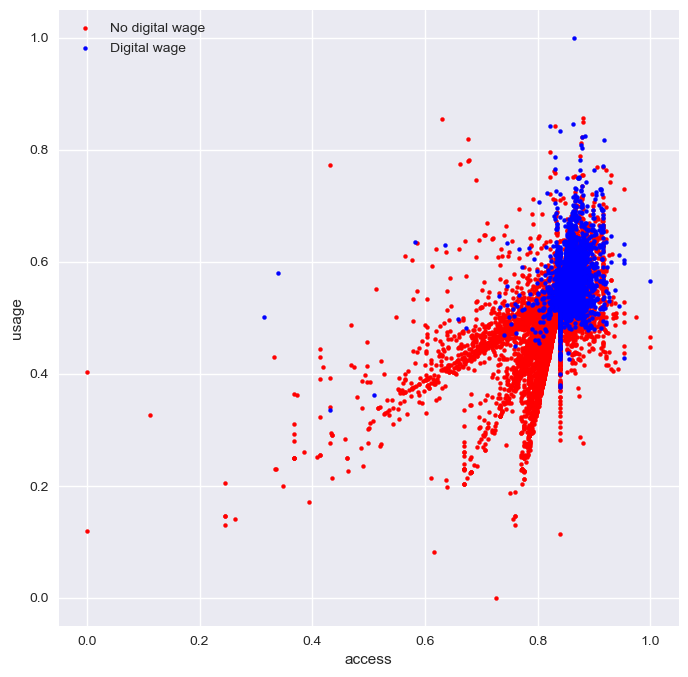

In [56]:
plt.figure(figsize=(8,8))
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=32, color="#ff0000",
            marker='.')
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=32, color="#0000ff",
            marker='.')
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
#plt.xlim([0.25,1.05])
#plt.ylim([-0.05,.75])
plt.savefig('../../images/find_eca')
plt.show()

In [57]:
IND_fin['access'].describe()

count    18022.000000
mean         0.834834
std          0.048712
min          0.000000
25%          0.826827
50%          0.845120
75%          0.854752
max          1.000000
Name: access, dtype: float64

In [58]:
IND_fin['usage'].describe()

count    18022.000000
mean         0.520745
std          0.062984
min          0.000000
25%          0.497537
50%          0.529893
75%          0.552715
max          1.000000
Name: usage, dtype: float64

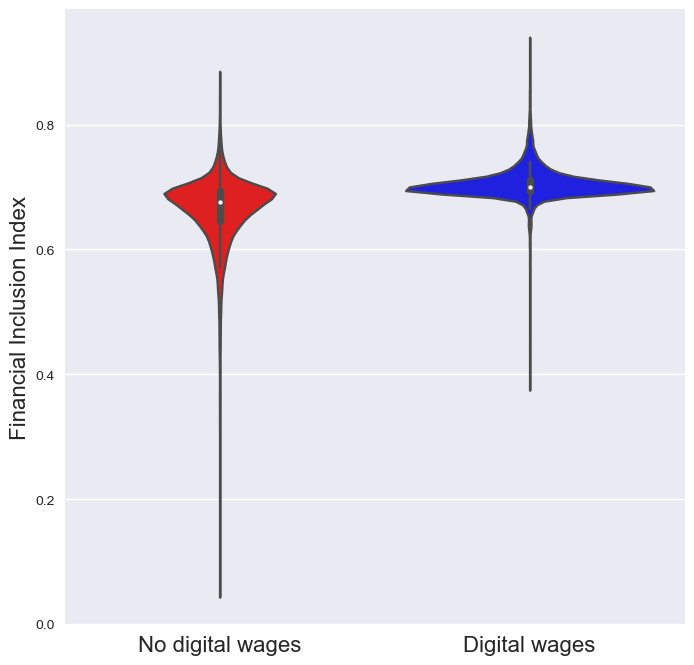

In [59]:
colors = ["#ff0000", "#0000ff"]
plt.figure(figsize=(8, 8))
sns.violinplot(x='fin34a', y='index', data=IND_fin, palette= colors)
custom_category_names = ['No digital wages', 'Digital wages']
plt.xticks(range(len(custom_category_names)), custom_category_names, fontsize=16)
plt.xlabel('')
plt.ylabel('Financial Inclusion Index', fontsize=16)
plt.savefig('../../images/ind_eca')

# Show the plot
plt.show()

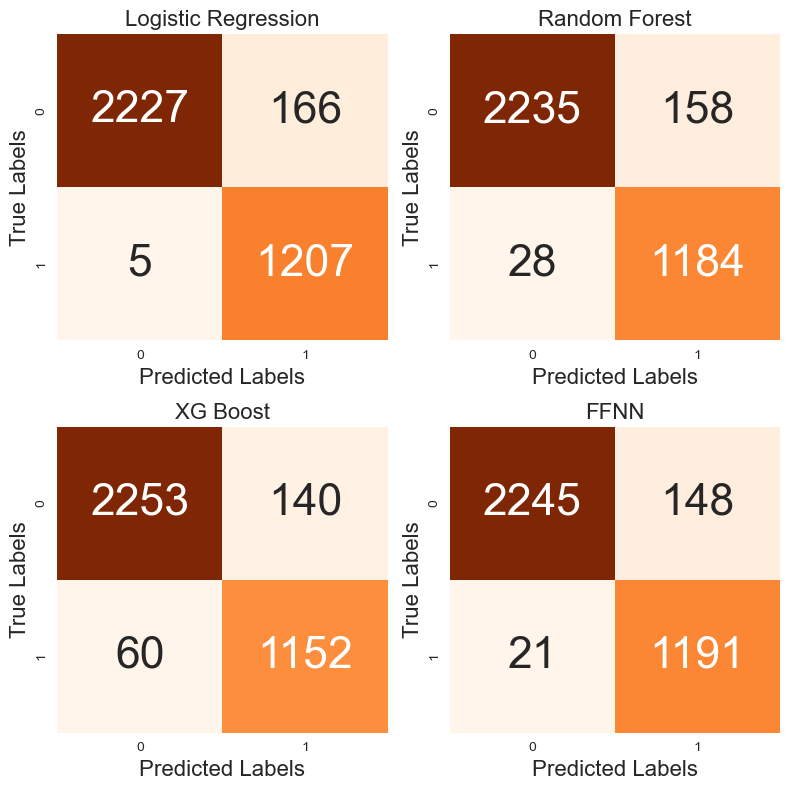

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cm= [cm1, cm2, cm3, cm4]
mods= ["Logistic Regression", "Random Forest", "XG Boost", "FFNN"]
# Compute and plot confusion matrices
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(cm[i], annot=True, cmap="Oranges", fmt='d', ax=ax, cbar=False, 
                annot_kws={"fontsize": 32})
    ax.set_title(f"{mods[i]}", fontsize=16)
    ax.set_xlabel("Predicted Labels", fontsize=16)
    ax.set_ylabel("True Labels", fontsize=16)

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('../../images/comat_eca.png')
# Display the plot
plt.show()

## Feature importance

[15:10:31] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


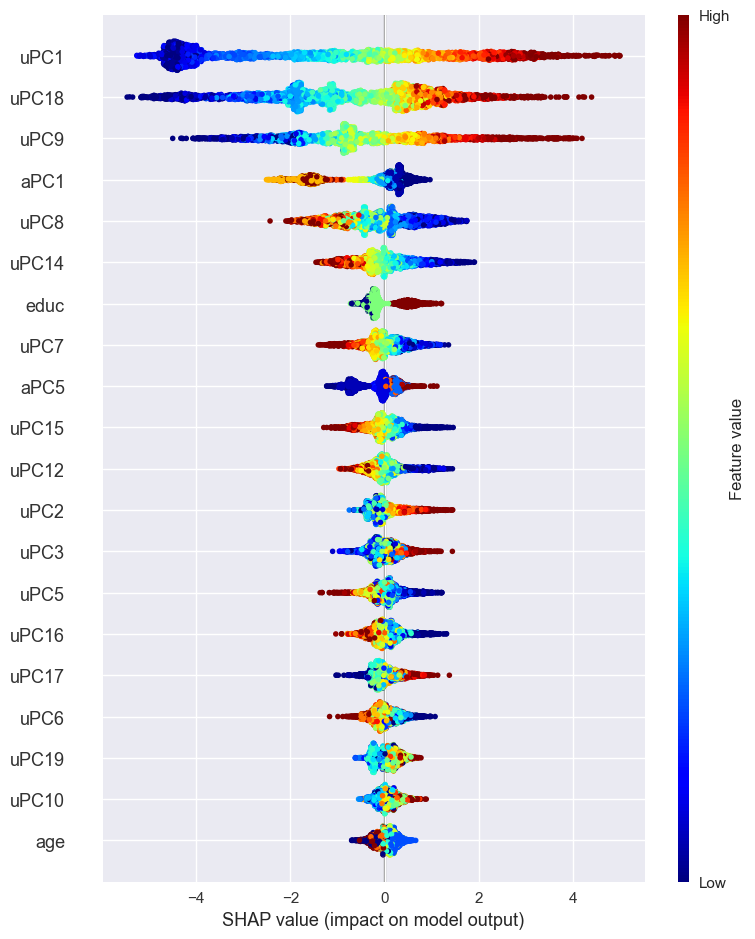

In [61]:
explainer = shap.TreeExplainer(best_xgb)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test, cmap= "jet")

In [62]:
u= mca_u.column_contributions_
u= u.rename(columns=new_column_names_u)
a= mca_a.column_contributions_
a= a.rename(columns=new_column_names_a)

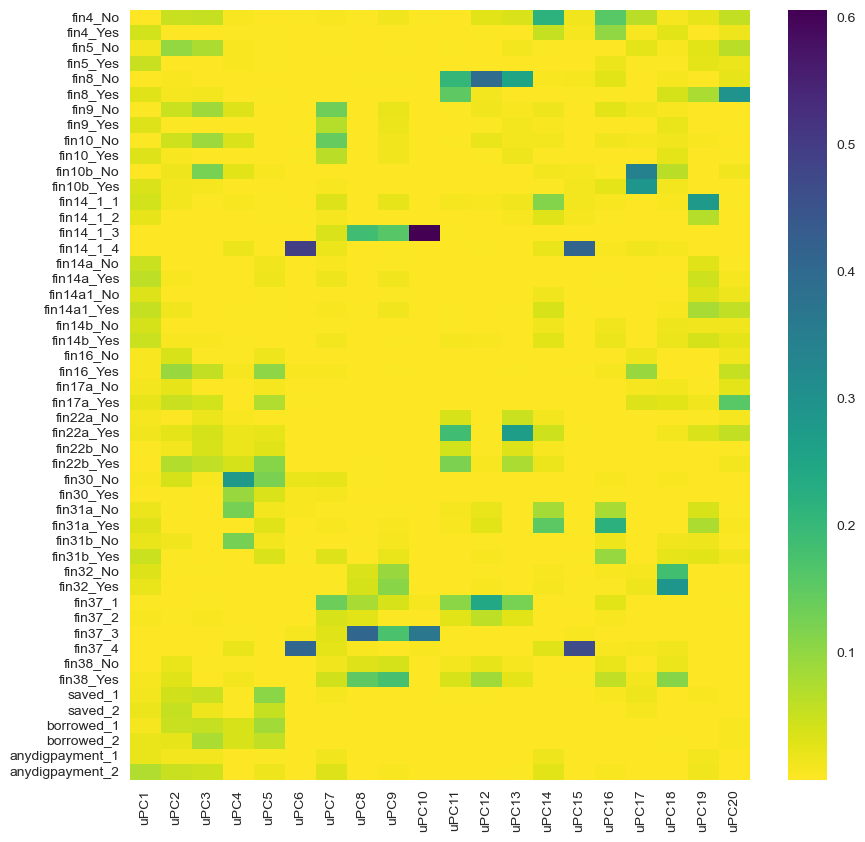

In [63]:
plt.figure(figsize=(10,10))
sns.heatmap(u, annot=False, cmap="viridis_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/us_eca.png')
plt.show()

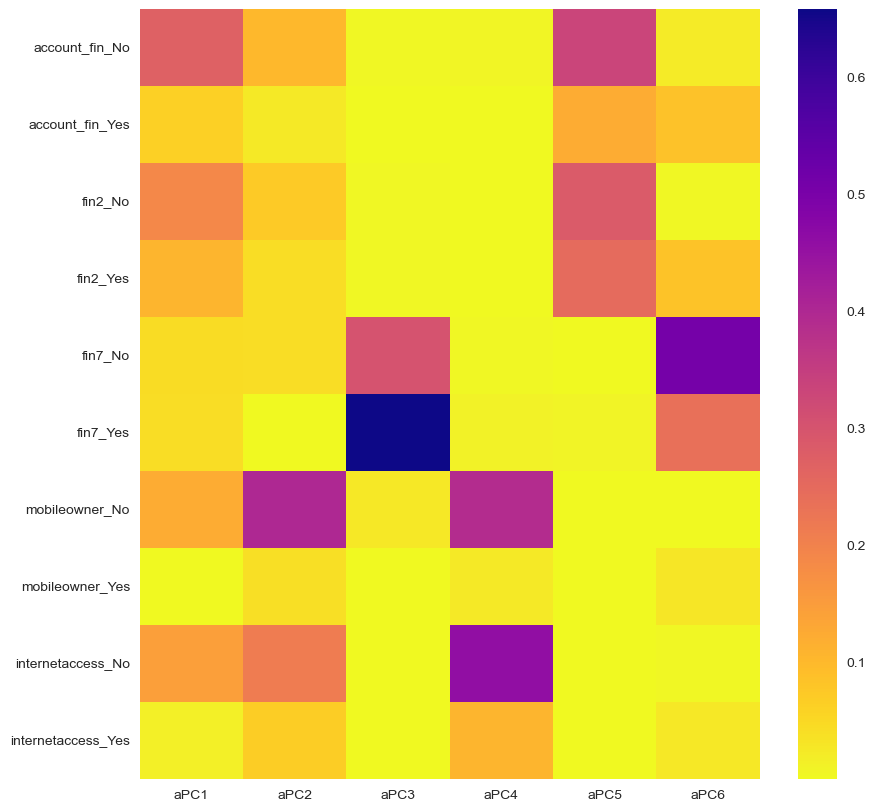

In [64]:
plt.figure(figsize=(10,10))
sns.heatmap(a, annot=False, cmap="plasma_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/acc_eca.png')
plt.show()

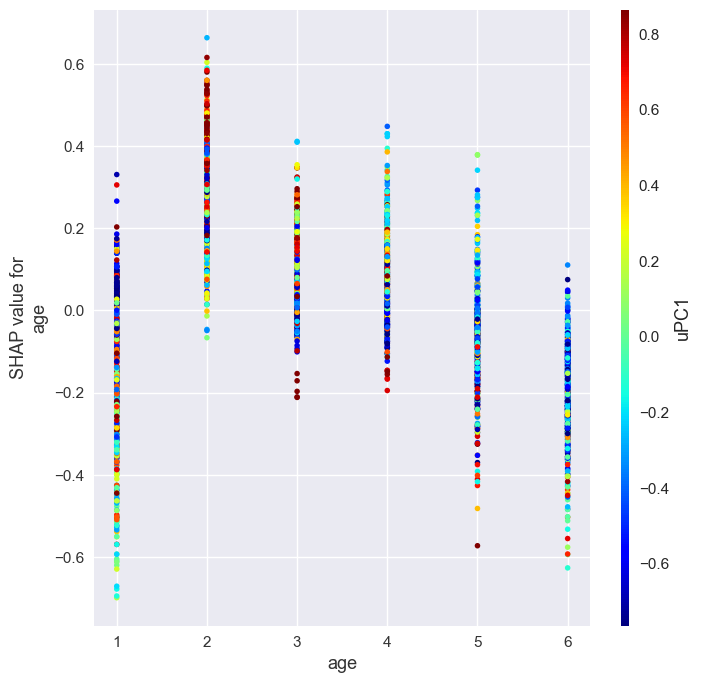

In [65]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('age', shap_values, X_test, interaction_index="uPC1", ax=ax, cmap="jet")
plt.show()

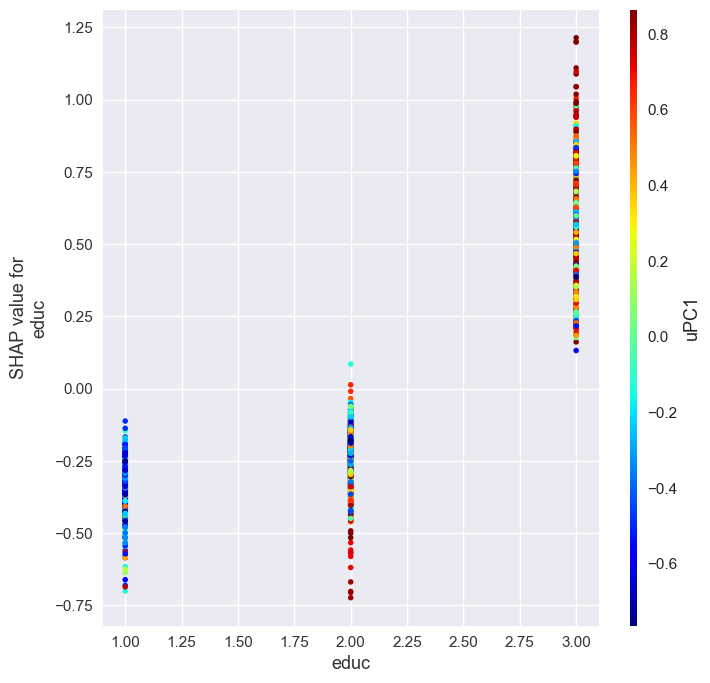

In [66]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('educ', shap_values, X_test, interaction_index="uPC1", ax=ax, cmap="jet")
plt.show()

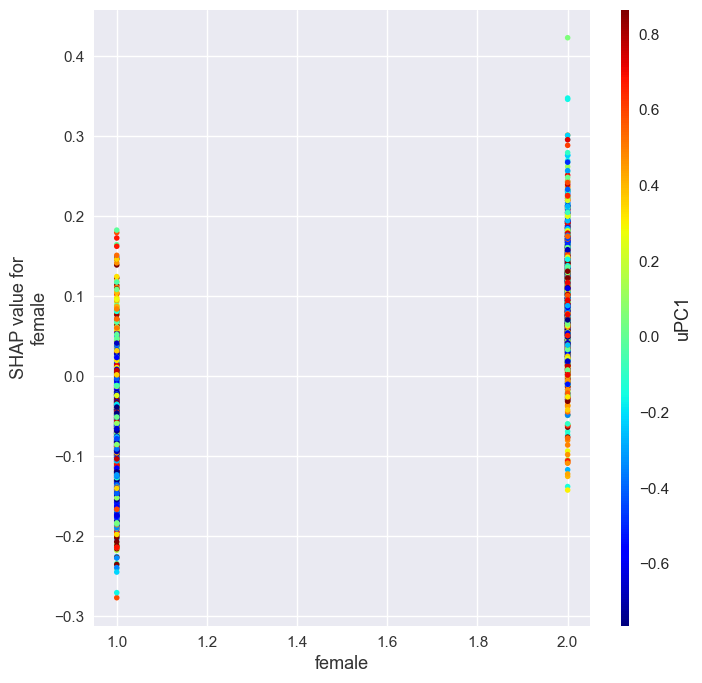

In [67]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax, cmap="jet")
plt.show()

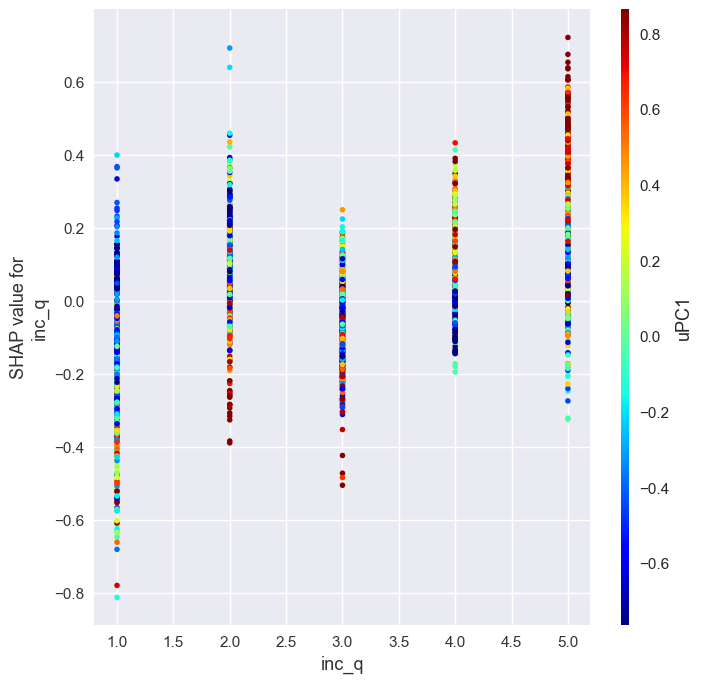

In [68]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('inc_q', shap_values, X_test, interaction_index="uPC1", ax=ax, cmap="jet")
plt.show()

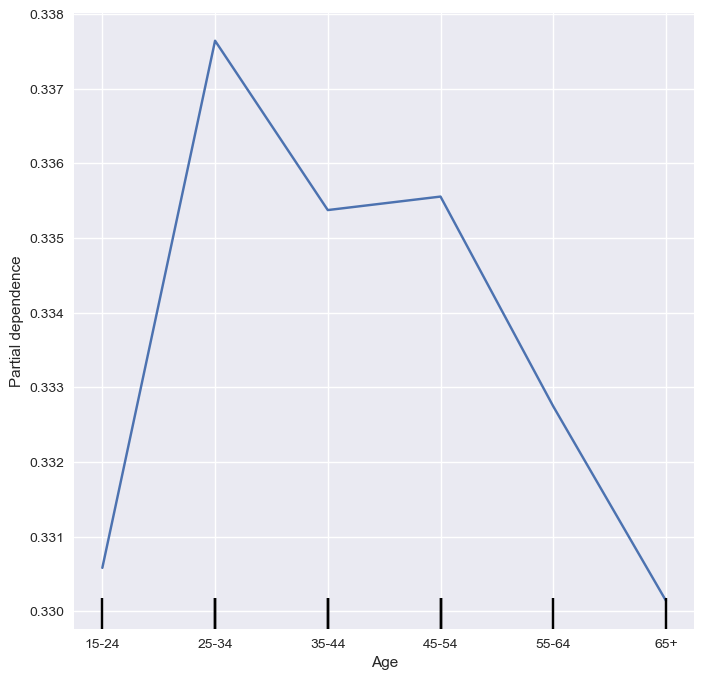

In [69]:
fig, ax= plt.subplots(figsize=(8,8))
p_age= PartialDependenceDisplay.from_estimator(best_xgb, X_train, ['age'], ax=ax)
new_labels = ['15-24', '25-34', '35-44', '45-54', '55-64', '65+']
x=[1,2,3,4,5,6]
plt.xticks(x, new_labels)
plt.xlabel('Age')
plt.savefig('../../images/pd_age_eca.png')
plt.show()

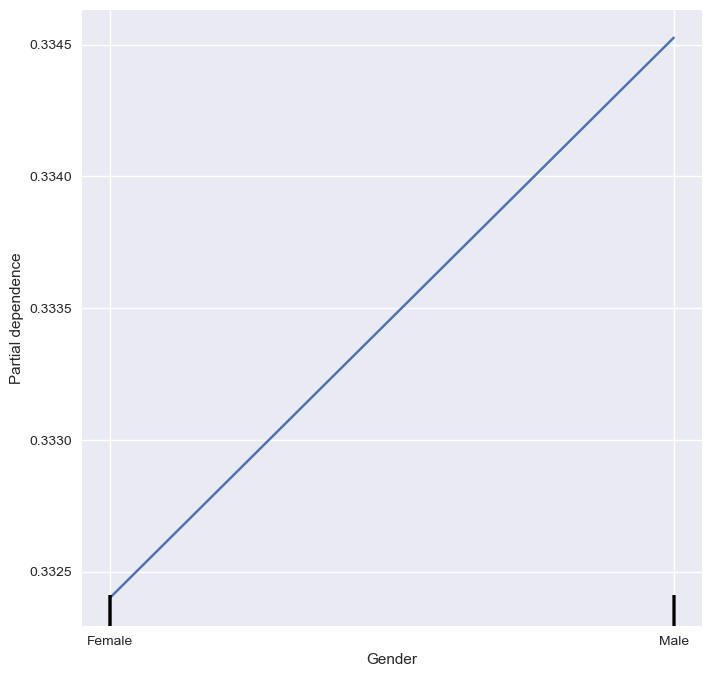

In [70]:
fig, ax= plt.subplots(figsize=(8,8))
p_female= PartialDependenceDisplay.from_estimator(best_xgb, X_train, ['female'], ax=ax)
new_labels = ['Female', 'Male']
x=[1,2]
plt.xticks(x, new_labels)
plt.xlabel('Gender')
plt.savefig('../../images/pd_gen_eca.png')
plt.show()

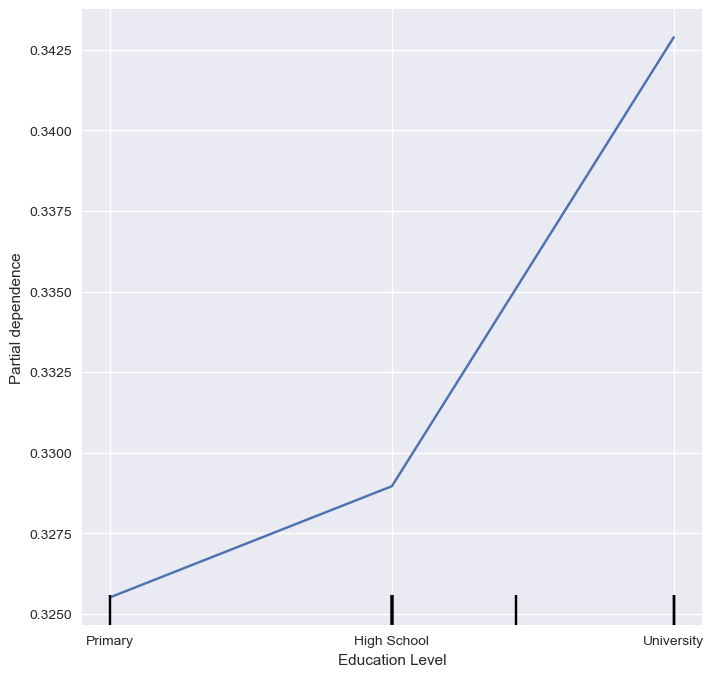

In [71]:
fig, ax= plt.subplots(figsize=(8,8))
p_educ= PartialDependenceDisplay.from_estimator(best_xgb, X_train, ['educ'], ax=ax)
new_labels = ['Primary', 'High School', 'University']
x=[1,2,3]
plt.xticks(x, new_labels)
plt.xlabel('Education Level')
plt.savefig('../../images/pd_educ_eca.png')
plt.show()

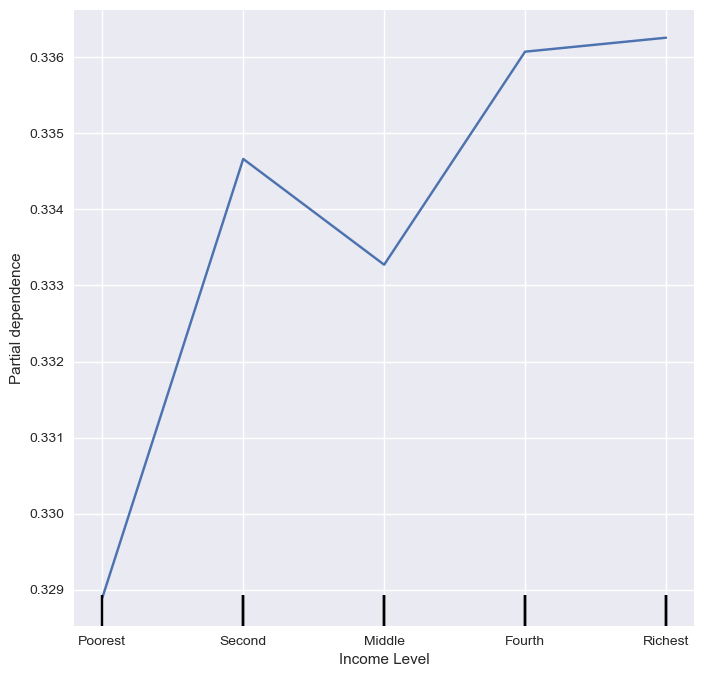

[CV] END ...............C=1, class_weight={0: 0.62, 1: 0.92}; total time=   0.1s
[CV] END class_weight={0: 0.49, 1: 0.72}, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=132; total time=   3.1s
[CV] END ...............C=1, class_weight={0: 0.62, 1: 0.92}; total time=   0.1s
[CV] END class_weight={0: 0.49, 1: 0.72}, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=132; total time=   3.2s
[CV] END class_weight={0: 0.49, 1: 0.72}, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=132; total time=   3.0s
[CV] END ...............C=1, class_weight={0: 0.62, 1: 0.92}; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=376, reg_alpha=0.5, reg_lambda=0.1, subsample=0.5; total time=   1.6s
[CV] END class_weight={0: 0.49, 1: 0.72}, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=132; total time=   3.0

In [72]:
fig, ax= plt.subplots(figsize=(8,8))
p_inc= PartialDependenceDisplay.from_estimator(best_xgb, X_train, ['inc_q'], ax=ax)
new_labels = ['Poorest', 'Second', 'Middle', 'Fourth', 'Richest']
x=[1,2,3,4,5]
plt.xticks(x, new_labels)
plt.xlabel('Income Level')
plt.savefig('../../images/pd_inc_eca.png')
plt.show()